In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.patches as mpatches
import os 

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use("fivethirtyeight")

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
gmx_blue = '#000058'
avax_red = '#DE4437'
gns_green = '#3deca7'

In [3]:
%run helper.py

In [4]:
# input
start_date = '2021-11-02'
end_date = '2022-11-09'

In [5]:
# read and subset data
df = pd.read_pickle('data/open_prices_2022-11-09.pkl').loc[start_date:end_date]
df

,GMX,GNS
date,,
2021-12-01,34.1043,0.4757
2021-12-02,33.0048,0.5121
2021-12-03,30.8157,0.6355
2021-12-04,27.9526,0.6139
2021-12-05,29.6490,0.7095
...,...,...
2022-11-05,43.2112,3.8900
2022-11-06,40.9000,3.9200
2022-11-07,38.3025,3.8499


## Calculate and Plot the Efficient Frontier and Min-Variance Portfolio

Portfolio is made up of only two tokens, namely, GMX and GNS.

In [6]:
# calculate daily returns
simple_rets = df.pct_change().dropna()
simple_rets.head()

,GMX,GNS
date,,
2021-12-02,-0.0322,0.0763
2021-12-03,-0.0663,0.2412
2021-12-04,-0.0929,-0.0341
2021-12-05,0.0607,0.1558
2021-12-06,-0.0927,-0.0829


In [7]:
# calculate annualized mean return and volatility of the GMX-GNS portfolio 
# using all downloaded data, assuming equal weights
weights = [1/2, 1/2]
print('Mean return:', 
      calc_portfolio_ret_avg(simple_rets.mean(), weights, ndays_per_year=365))
print('Volatility:', 
      calc_portfolio_ret_std(simple_rets, weights, ndays_per_year=365))

Mean return: 2.4724441302820295
Volatility: 1.3180361790770623


In [8]:
# randomly generate 1000 pairs of weights, and every time we have a new pair of 
# weights, we have a new portfolio with a different mean return and volatility. 
rets = []
stds = []
wts = []
for i in range(1000):
    weights = generate_weights(2)
    rets.append(calc_portfolio_ret_avg(simple_rets.mean(), weights))
    stds.append(calc_portfolio_ret_std(simple_rets, weights))
    wts.append(weights)

In [9]:
# find the pair of weights that results in the minimum variance portfolio
minvar_wt_gmx = wts[stds.index(min(stds))][0]
minvar_wt_gns = wts[stds.index(min(stds))][1]

In [10]:
dat = pd.DataFrame({'vol': stds, 'ret': rets})

# draw main figure
fig_title = 'Efficient Frontier\n({:} ~ {:})'.format(start_date, end_date)
fig = px.scatter(
    dat, x='vol', y='ret', color_discrete_sequence=['lightgray'],
    labels=dict(vol="Portfolio Volatility", ret='Portfolio Return'),
    title=fig_title
)

In [11]:
# all in GMX
gmx_x = simple_rets.std()['GMX']*np.sqrt(365)
gmx_y = simple_rets.mean()['GMX']*365 
# all in GNS
gns_x = simple_rets.std()['GNS']*np.sqrt(365)
gns_y = simple_rets.mean()['GNS']*365
# min-var portfolio
minvar_x = min(stds)
minvar_y = rets[stds.index(min(stds))]

# add these portfolios to figure
fig.add_trace(
    go.Scatter(name='GMX 0%, GNS 100%', x=[gns_x], y=[gns_y], mode='markers',
               marker=dict(size=12, color=[gns_green], line=dict(width=2)))
)
fig.add_trace(
    go.Scatter(name='GMX 100%, GNS 0%', x=[gmx_x], y=[gmx_y], mode='markers',
               marker=dict(size=12, color=[gmx_blue], line=dict(width=2)))
)
legend_minvar = \
    'Min-Variance: GMX {:.0%}, GNS {:.0%}'.format(minvar_wt_gmx, minvar_wt_gns)
fig.add_trace(
    go.Scatter(name=legend_minvar, x=[minvar_x], y=[minvar_y], mode='markers',
               marker=dict(size=12, color=[avax_red], line=dict(width=2)))
)

# add a dashed horizontal line across the minvar portfolio
fig.add_hline(y=minvar_y, line_dash="dash", line_color="#c4c3d0")
# add a dashed vertical line across the 100%-GMX portfolio
fig.add_vline(x=gmx_x, line_dash="dash", line_color="#c4c3d0")

# aesthetics
fig.update_layout(plot_bgcolor="#f8f8ff", 
        yaxis_tickformat = ',.0%',
        xaxis_tickformat = ',.0%',
        # legend=dict(orientation="h"),
        font=dict(size=18),
        autosize=False,
        width=1200,
        height=600,
    )
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#e3dac9')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#e3dac9')

#### Remark: 

- each dot is a portfolio.
- avoid the bottom half of the curve because you can always do better for the same volatility. For example, given a volatility, draw a vertical line, and you'd want to pick the portfolio at the intersection of the vertical line and the top half of the curve.
- if you want to mute volatility, the min-variance portfolio (red dot) is a good choice.

## Calculate min-variance portfolios for different start dates

In [12]:
minvar_stds = []
minvar_rets = []
minvar_wts_gmx = []
minvar_wts_gns = []
n = int(len(simple_rets) * 0.7)  # use at least 30% data for calculation to ensure robustness of results
for i in range(n):
    ha = simple_rets.iloc[i:]
    rets = []
    stds = []
    wts = []
    for i in range(500): # generate 500 pairs of weights and hence 500 new portfolios. Lower it to decrease computation time.
        weights = generate_weights(2)
        rets.append(calc_portfolio_ret_avg(ha.mean(), weights))
        stds.append(calc_portfolio_ret_std(ha, weights))
        wts.append(weights)
    minvar_stds.append(min(stds)) 
    minvar_rets.append(rets[stds.index(min(stds))])
    minvar_wts_gmx.append(wts[stds.index(min(stds))][0])
    minvar_wts_gns.append(wts[stds.index(min(stds))][1])

In [13]:
# collect all the min-variance portfolios into a data frame
minvar_portfolios = pd.DataFrame(
    {"std": minvar_stds, "ret": minvar_rets, 
     "GMX %":minvar_wts_gmx, "GNS %":minvar_wts_gns}, 
    index=simple_rets.index[:n])
minvar_portfolios.index.name = 'start date'
minvar_portfolios.head().style.format('{:.0%}')

,std,ret,GMX %,GNS %
start date,,,,
2021-12-02 00:00:00,131%,236%,55%,45%
2021-12-03 00:00:00,132%,235%,55%,45%
2021-12-04 00:00:00,132%,229%,54%,46%
2021-12-05 00:00:00,132%,236%,54%,46%
2021-12-06 00:00:00,131%,227%,54%,46%


In [14]:
minvar_portfolios.tail().style.format('{:.0%}')

,std,ret,GMX %,GNS %
start date,,,,
2022-07-22 00:00:00,107%,308%,42%,58%
2022-07-23 00:00:00,107%,309%,42%,58%
2022-07-24 00:00:00,107%,321%,43%,57%
2022-07-25 00:00:00,108%,316%,43%,57%
2022-07-26 00:00:00,108%,318%,43%,57%


## Analyze these min-variance portfolios

In [15]:
def plt_histogram(x, title, xlab, nbins=50, xaxis_nticks=8):
    x.hist(bins=nbins)
    plt.title(title)
    plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    steps  = (max(x) - min(x)) / xaxis_nticks
    plt.xticks(np.arange(min(x), max(x)+steps, steps))
    plt.xlabel(xlab)
    plt.ylabel('Frequency')

In [16]:
os.makedirs('png', exist_ok=True)

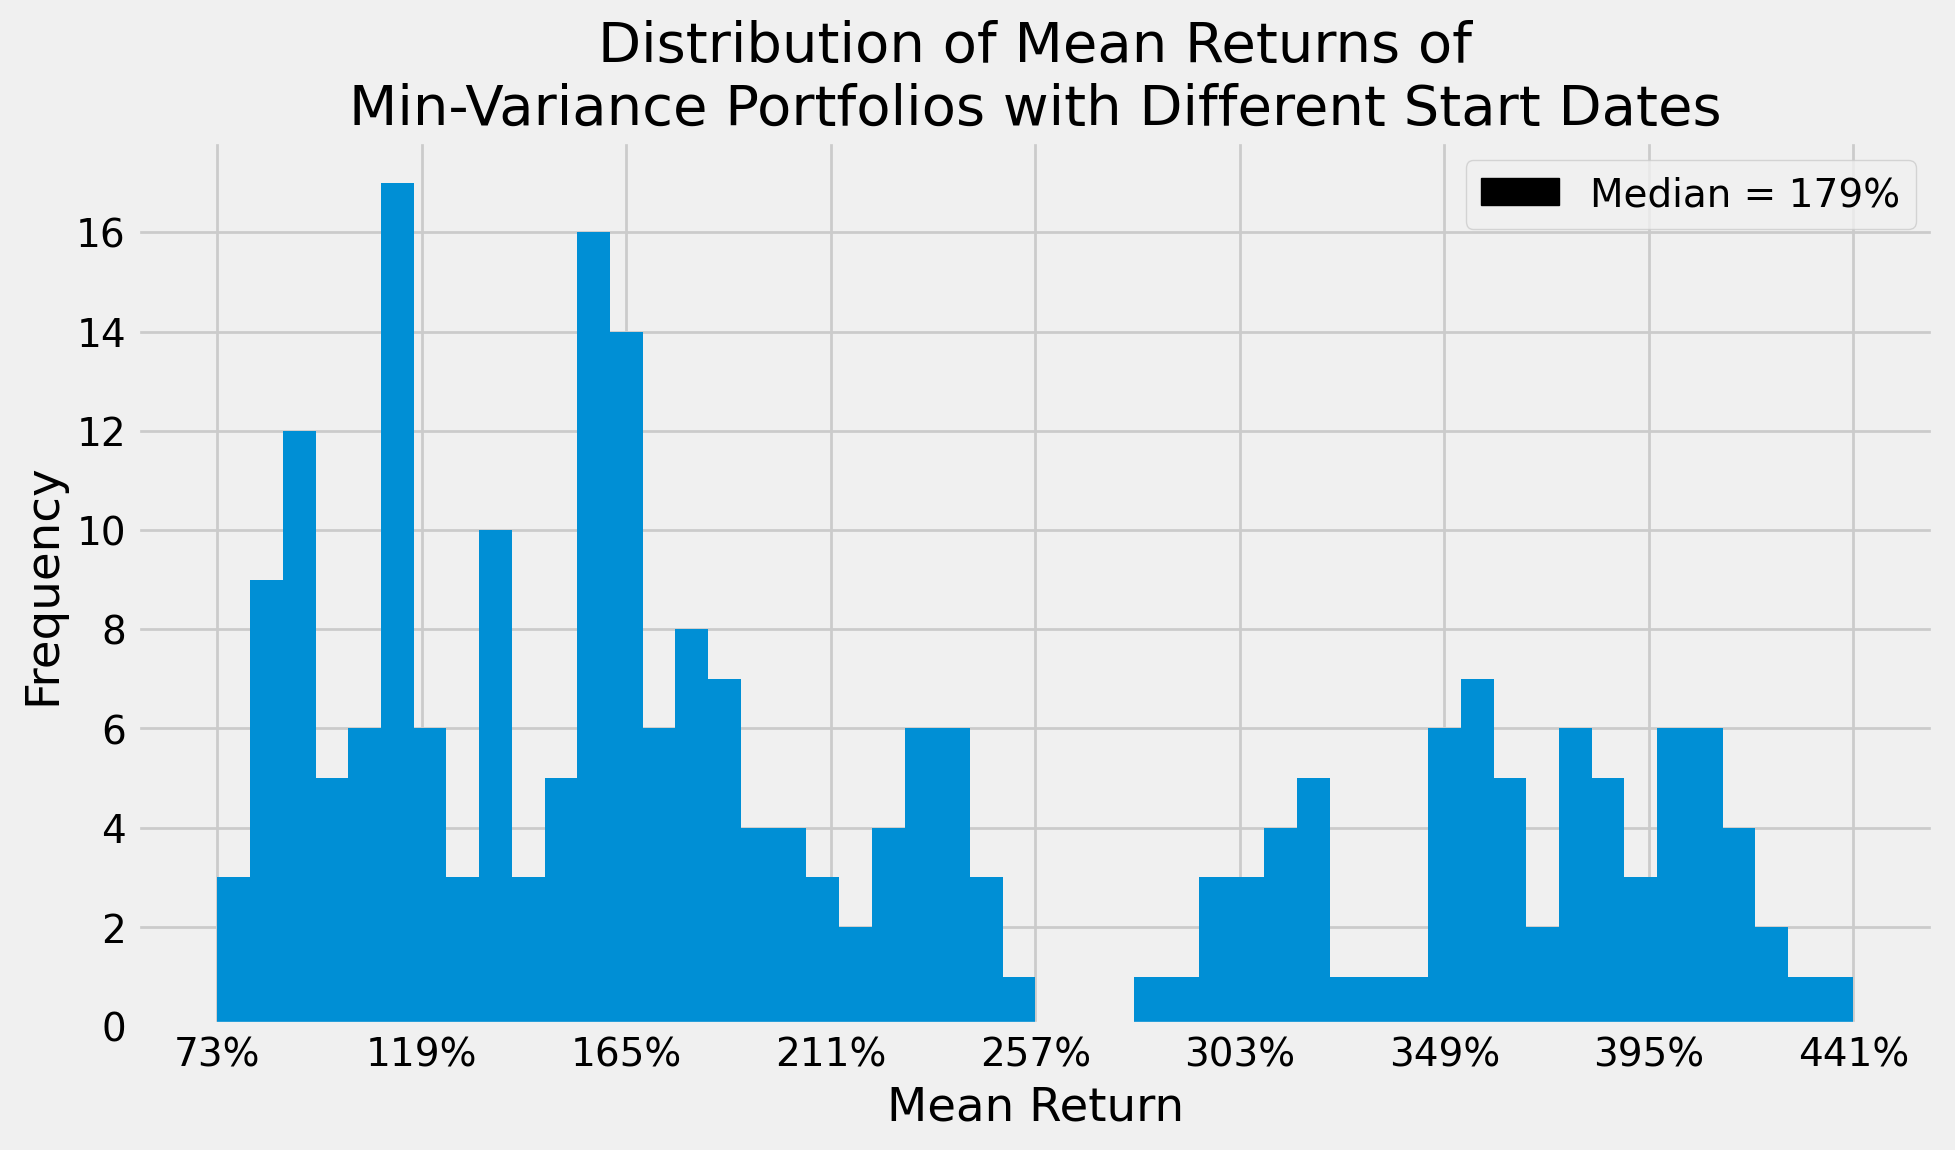

In [17]:
# plot distribution of mean returns
fig_title = 'Distribution of Mean Returns of\nMin-Variance Portfolios with Different Start Dates'
plt_histogram(minvar_portfolios.ret, fig_title, xlab='Mean Return')

# make legend to show the median value
med = minvar_portfolios['ret'].median()
l1 = mpatches.Patch(color='black',  label='Median = {:.0%}'.format(med))
plt.legend(handles=[l1], loc='upper right')

# save
plt.tight_layout()
# plt.savefig(os.path.join('png', 'minvar_portfolios_meanrets.png'), dpi=300)

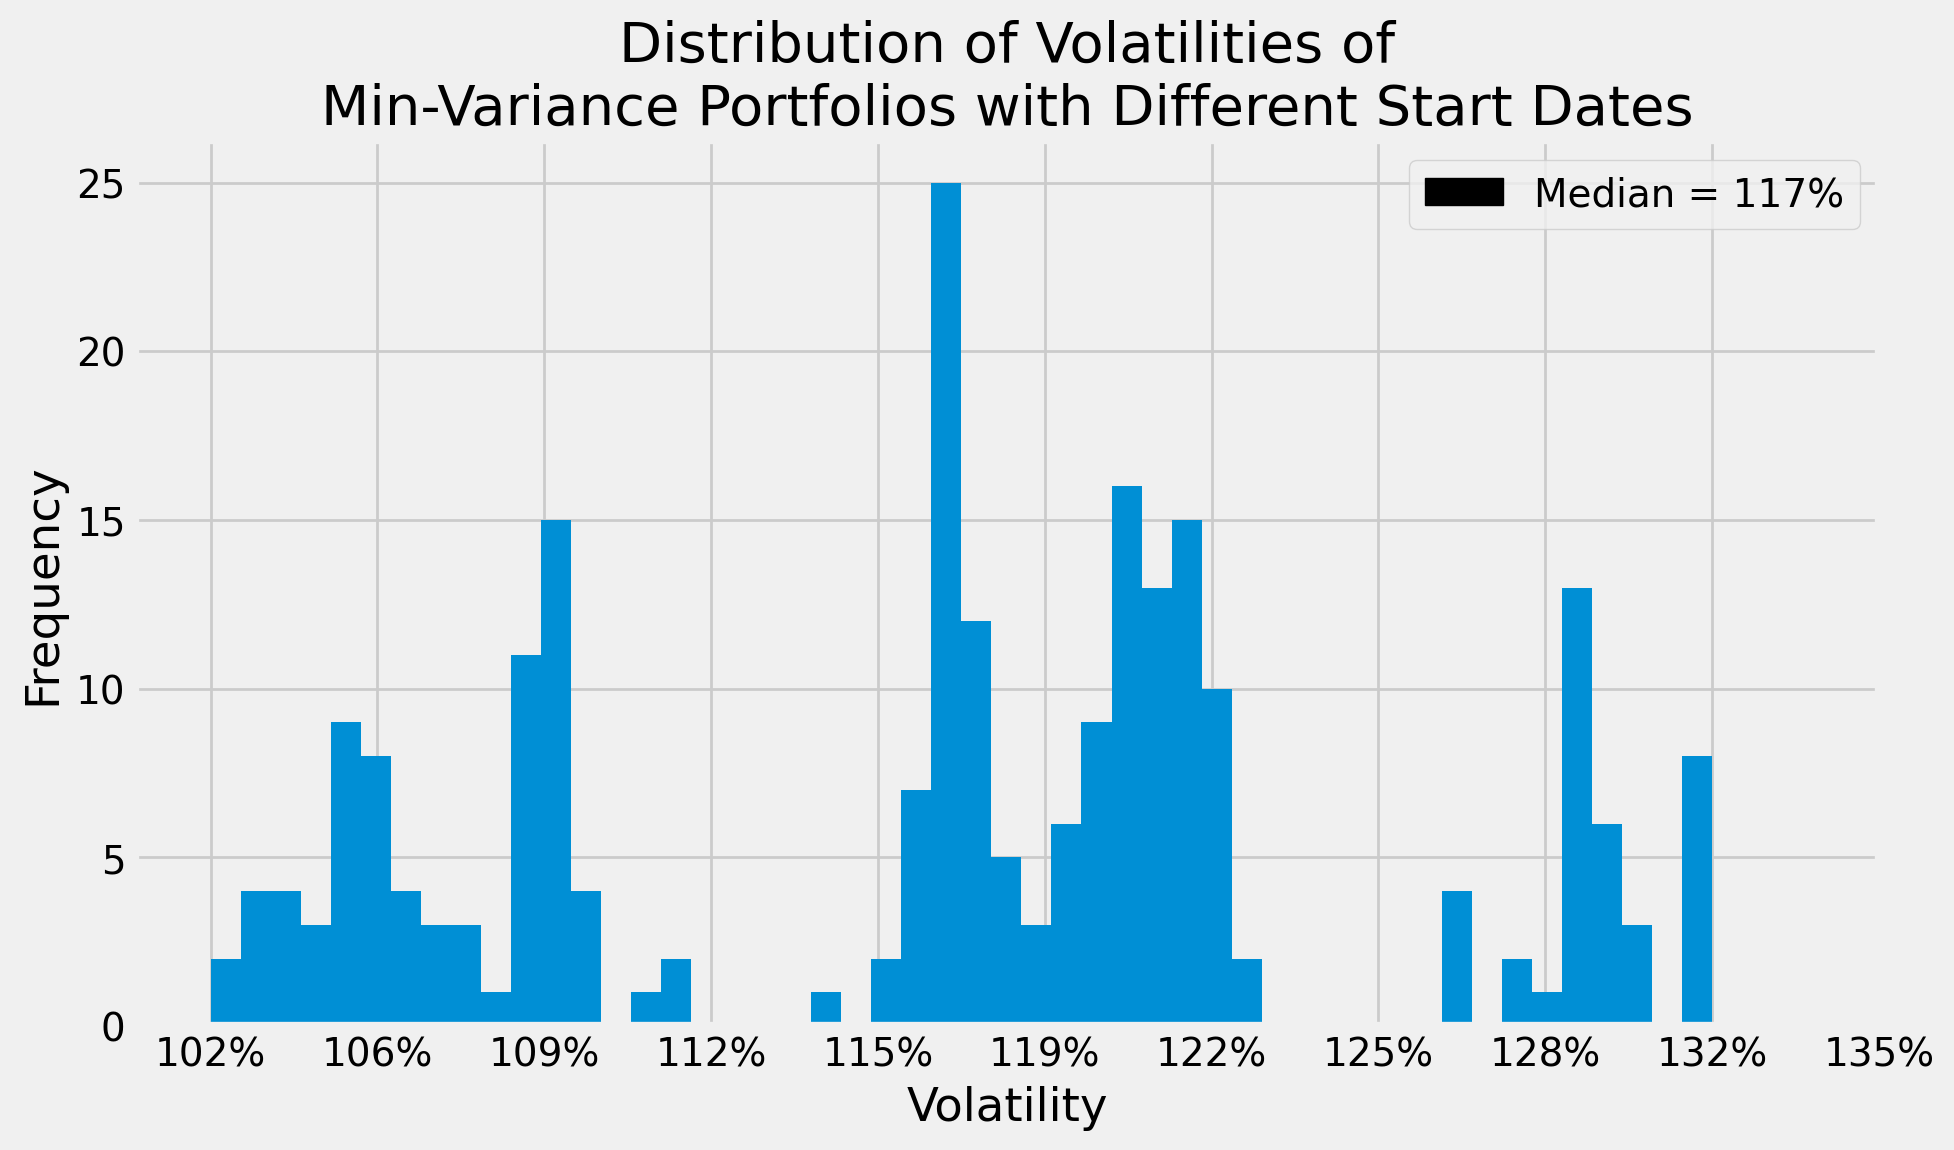

In [18]:
# plot distribution of volatilities
fig_title = 'Distribution of Volatilities of\nMin-Variance Portfolios with Different Start Dates'
plt_histogram(minvar_portfolios['std'], fig_title, xlab='Volatility', xaxis_nticks=9)

# make legend to show the median value
med = minvar_portfolios['std'].median()
l1 = mpatches.Patch(color='black',  label='Median = {:.0%}'.format(med))
plt.legend(handles=[l1], loc='upper right')

# save
plt.tight_layout()
# plt.savefig(os.path.join('png', 'minvar_portfolios_vols.png'), dpi=300)

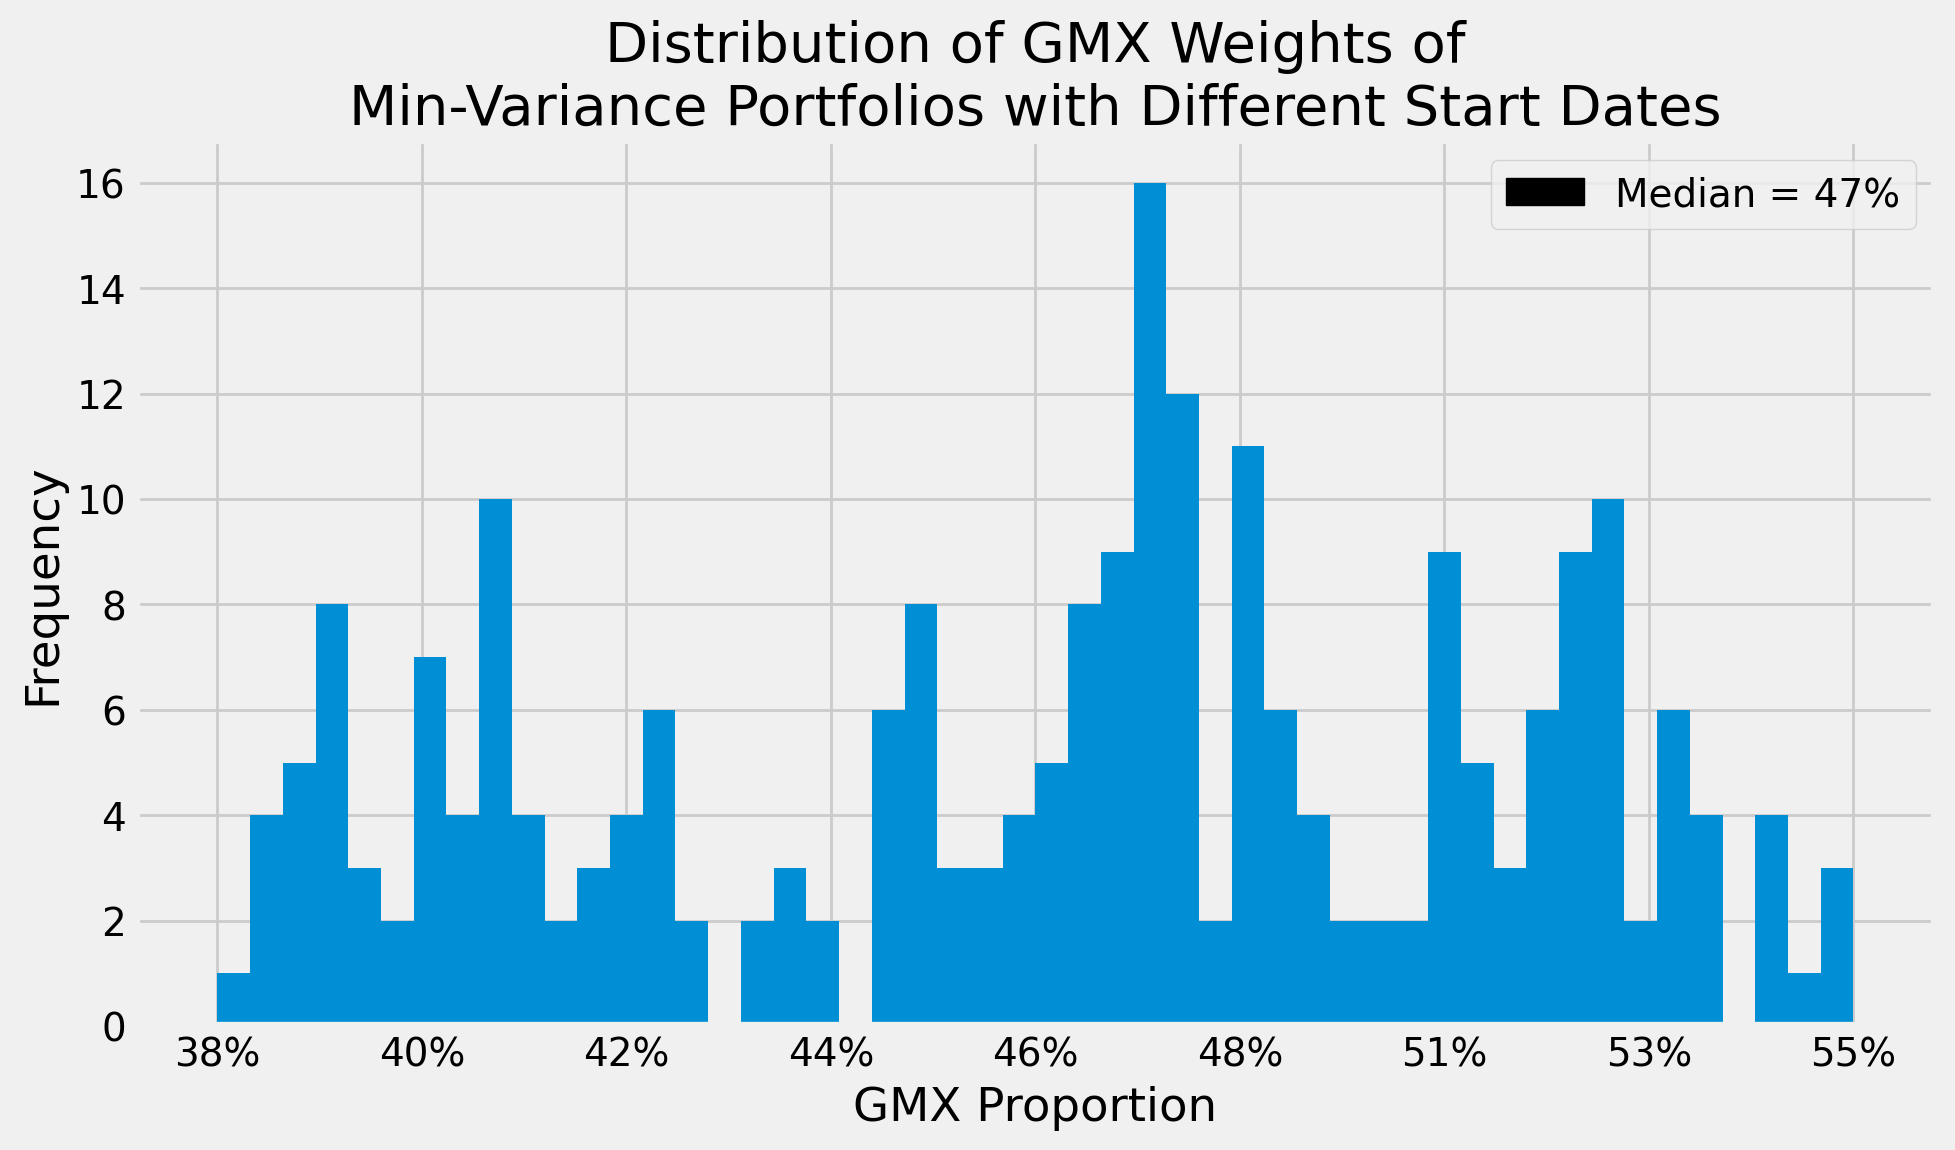

In [19]:
# plot distribution of GMX proportions
fig_title = 'Distribution of GMX Weights of\nMin-Variance Portfolios with Different Start Dates'
plt_histogram(minvar_portfolios['GMX %'], fig_title, xlab='GMX Proportion')

# make legend to show the median value
med = minvar_portfolios['GMX %'].median()
l1 = mpatches.Patch(color='black',  label='Median = {:.0%}'.format(med))
plt.legend(handles=[l1], loc='upper right')

# save
plt.tight_layout()
# plt.savefig(os.path.join('png', 'minvar_portfolios_weights_gmx.png'), dpi=300)

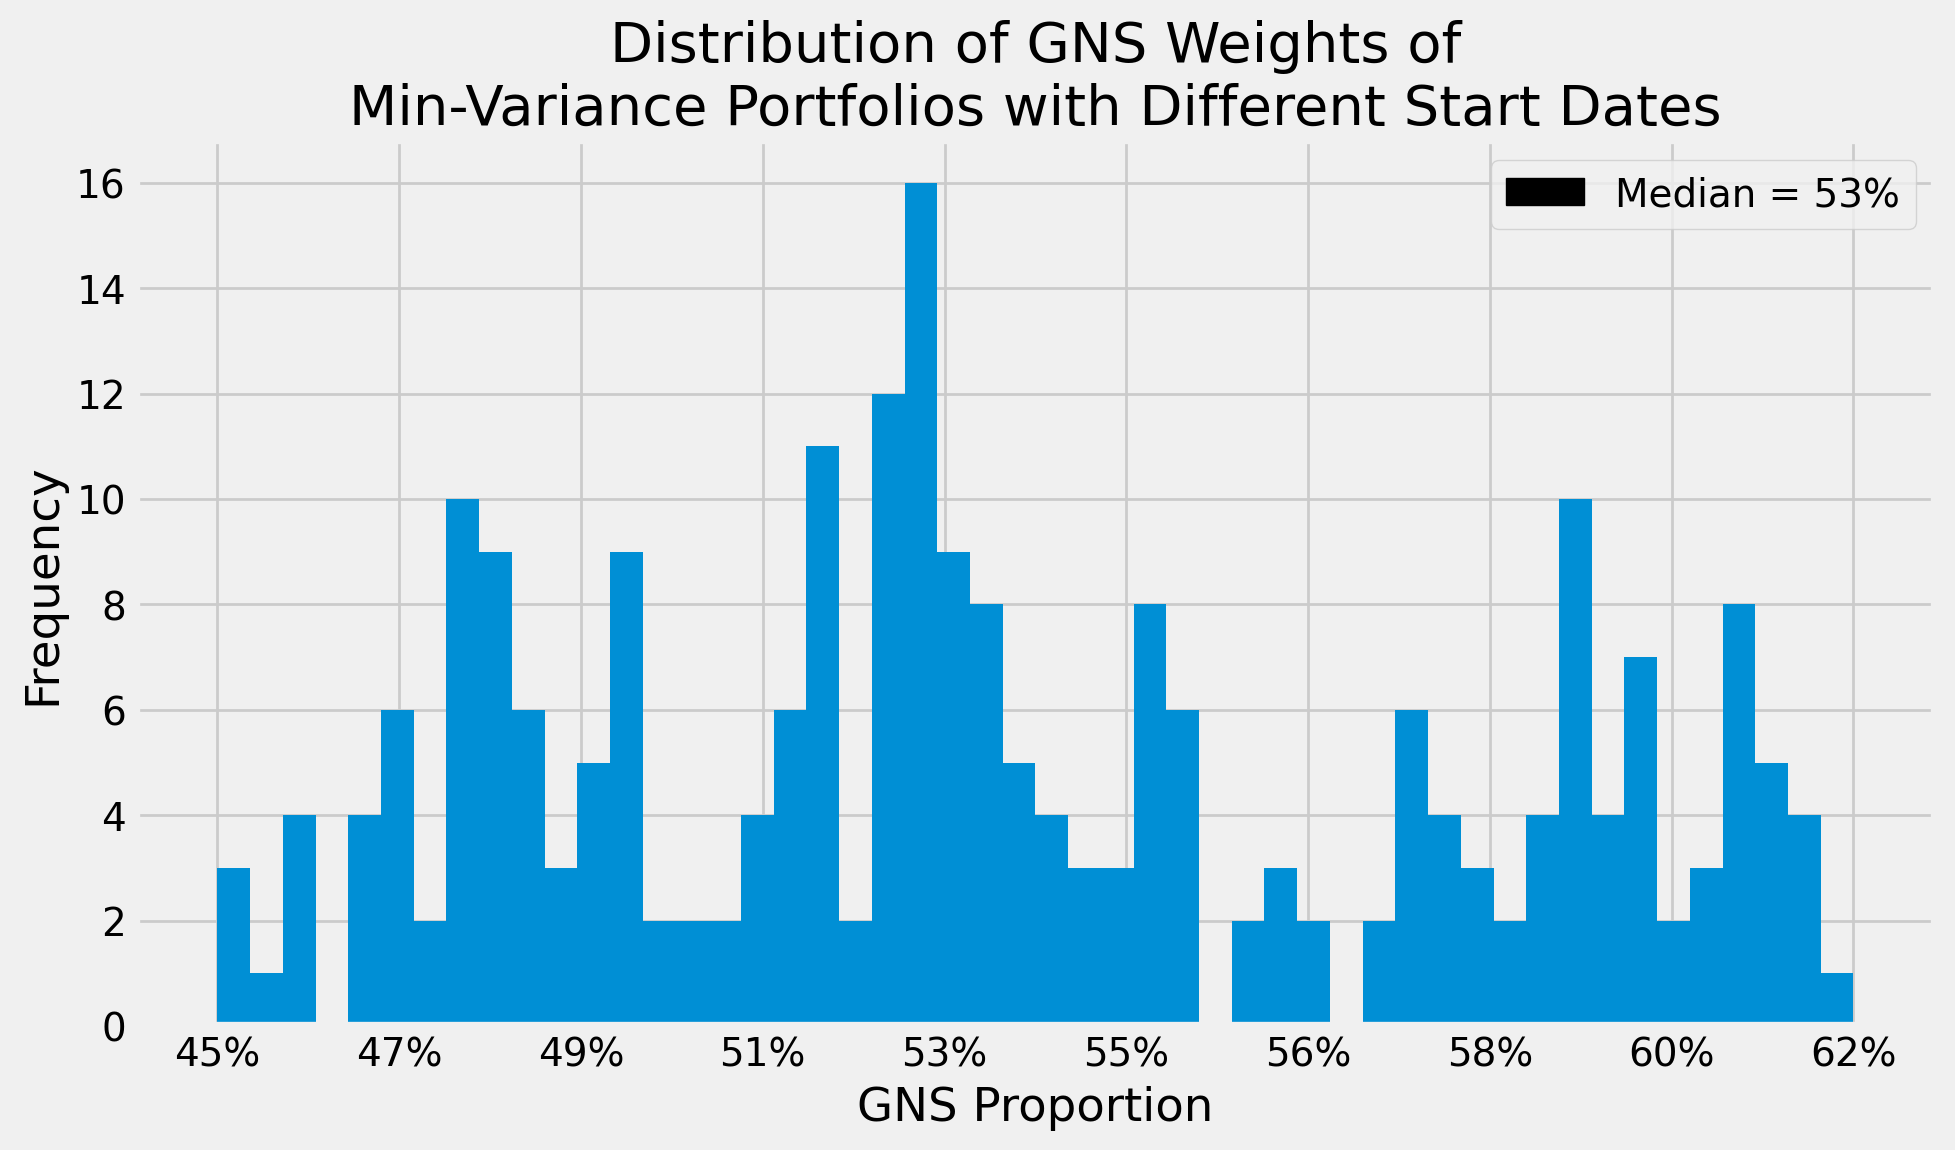

In [20]:
# plot distribution of GNS proportions
fig_title = 'Distribution of GNS Weights of\nMin-Variance Portfolios with Different Start Dates'
plt_histogram(minvar_portfolios['GNS %'], fig_title, xlab='GNS Proportion', xaxis_nticks=9)

# make legend to show the median value
med = minvar_portfolios['GNS %'].median()
l1 = mpatches.Patch(color='black',  label='Median = {:.0%}'.format(med))
plt.legend(handles=[l1], loc='upper right')

# save
plt.tight_layout()
# plt.savefig(os.path.join('png', 'minvar_portfolios_weights_gns.png'), dpi=300)